<a href="https://colab.research.google.com/github/BloodyUnicorn/Application-identification/blob/main/Application_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install scapy

     |████████████████████████████████| 1.1 MB 8.0 MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261554 sha256=6dd567ab5d34c9ad3c00e410a4cf9cbef40b65dbfea76b7ce9853d487347bc11
  Stored in directory: /root/.cache/pip/wheels/b9/6e/c0/0157e466a5e02d3ff28fc7587dff329b4a967a23b3f9b11385
Successfully built scapy


In [2]:
# pip install pytorch-lightning

In [3]:
from pathlib import Path
import os
import os.path
from google.colab import drive
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scapy.compat import raw
from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether
from scapy.packet import Padding
from scapy.utils import rdpcap, PcapReader
from scipy import sparse
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import sample
import matplotlib.pyplot as plt
import seaborn as sn
import math

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
# from pytorch_lightning import LightningModule
# from pytorch_lightning import Trainer
from torch.nn import functional as F

import time
from datetime import timedelta
from datetime import datetime
import pickle
import random
from prettytable import PrettyTable

# import sys
# sys.path.append('drive/MyDrive/deep_packet')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
## Colab setting
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


## Preprocessing

In [5]:
def remove_ether_header(packet):
    if Ether in packet:
        return packet[Ether].payload

    return packet


def mask_ip(packet):
    if IP in packet:
        packet[IP].src = '0.0.0.0'
        packet[IP].dst = '0.0.0.0'

    return packet


def pad_udp(packet):
    if UDP in packet:
        # get layers after udp
        layer_after = packet[UDP].payload.copy()

        # build a padding layer
        pad = Padding()
        pad.load = '\x00' * 12

        layer_before = packet.copy()
        layer_before[UDP].remove_payload()
        packet = layer_before / pad / layer_after

        return packet

    return packet


def packet_to_sparse_array(packet, max_length=1500):
    arr = np.frombuffer(raw(packet), dtype=np.uint8)[0: max_length]     # Divide to 255 later
    if len(arr) < max_length:
        pad_width = max_length - len(arr)
        arr = np.pad(arr, pad_width=(0, pad_width), constant_values=0)

    arr = sparse.csr_matrix(arr)
    return arr


def transform_packet(packet):
    if should_omit_packet(packet):
        return None

    packet = remove_ether_header(packet)
    packet = pad_udp(packet)
    packet = mask_ip(packet)

    arr = packet_to_sparse_array(packet)

    return arr

In [6]:
from pathlib import Path
from scapy.layers.dns import DNS
from scapy.layers.inet import TCP
from scapy.packet import Padding
from scapy.utils import rdpcap

# for app identification
PREFIX_TO_APP_ID = {
    # AIM chat
    'aim_chat_3a': 0,
    'aim_chat_3b': 0,
    'aimchat1': 0,
    'aimchat2': 0,
    # Email
    'email1a': 1,
    'email1b': 1,
    'email2a': 1,
    'email2b': 1,
    # Facebook
    'facebook_audio1a': 2,
    'facebook_audio1b': 2,
    'facebook_audio2a': 2,
    'facebook_audio2b': 2,
    'facebook_audio3': 2,
    'facebook_audio4': 2,
    'facebook_chat_4a': 2,
    'facebook_chat_4b': 2,
    'facebook_video1a': 2,
    'facebook_video1b': 2,
    'facebook_video2a': 2,
    'facebook_video2b': 2,
    'facebookchat1': 2,
    'facebookchat2': 2,
    'facebookchat3': 2,
    # FTPS
    'ftps_down_1a': 3,
    'ftps_down_1b': 3,
    'ftps_up_2a': 3,
    'ftps_up_2b': 3,
    # Gmail
    'gmailchat1': 4,
    'gmailchat2': 4,
    'gmailchat3': 4,
    # Hangouts
    'hangout_chat_4b': 5,
    'hangouts_audio1a': 5,
    'hangouts_audio1b': 5,
    'hangouts_audio2a': 5,
    'hangouts_audio2b': 5,
    'hangouts_audio3': 5,
    'hangouts_audio4': 5,
    'hangouts_chat_4a': 5,
    'hangouts_video1b': 5,
    'hangouts_video2a': 5,
    'hangouts_video2b': 5,
    # ICQ
    'icq_chat_3a': 6,
    'icq_chat_3b': 6,
    'icqchat1': 6,
    'icqchat2': 6,
    # Netflix
    'netflix1': 7,
    'netflix2': 7,
    'netflix3': 7,
    'netflix4': 7,
    # SCP
    'scp1': 8,
    'scpdown1': 8,
    'scpdown2': 8,
    'scpdown3': 8,
    'scpdown4': 8,
    'scpdown5': 8,
    'scpdown6': 8,
    'scpup1': 8,
    'scpup2': 8,
    'scpup3': 8,
    'scpup5': 8,
    'scpup6': 8,
    # SFTP
    'sftp1': 9,
    'sftp_down_3a': 9,
    'sftp_down_3b': 9,
    'sftp_up_2a': 9,
    'sftp_up_2b': 9,
    'sftpdown1': 9,
    'sftpdown2': 9,
    'sftpup1': 9,
    # Skype
    'skype_audio1a': 10,
    'skype_audio1b': 10,
    'skype_audio2a': 10,
    'skype_audio2b': 10,
    'skype_audio3': 10,
    'skype_audio4': 10,
    'skype_chat1a': 10,
    'skype_chat1b': 10,
    'skype_file1': 10,
    'skype_file2': 10,
    'skype_file3': 10,
    'skype_file4': 10,
    'skype_file5': 10,
    'skype_file6': 10,
    'skype_file7': 10,
    'skype_file8': 10,
    'skype_video1a': 10,
    'skype_video1b': 10,
    'skype_video2a': 10,
    'skype_video2b': 10,
    # Spotify
    'spotify1': 11,
    'spotify2': 11,
    'spotify3': 11,
    'spotify4': 11,
    # Torrent
    'torrent01': 12,
    # Tor
    'torfacebook': 13,
    'torgoogle': 13,
    'tortwitter': 13,
    'torvimeo1': 13,
    'torvimeo2': 13,
    'torvimeo3': 13,
    'toryoutube1': 13,
    'toryoutube2': 13,
    'toryoutube3': 13,
    # Vimeo
    'vimeo1': 14,
    'vimeo2': 14,
    'vimeo3': 14,
    'vimeo4': 14,
    # Voipbuster
    'voipbuster1b': 15,
    'voipbuster2b': 15,
    'voipbuster3b': 15,
    'voipbuster_4a': 15,
    'voipbuster_4b': 15,
    # Youtube
    'youtube1': 16,
    'youtube2': 16,
    'youtube3': 16,
    'youtube4': 16,
    'youtube5': 16,
    'youtube6': 16,
    'youtubehtml5_1': 16,
}

ID_TO_APP = {
    0: 'AIM Chat',
    1: 'Email',
    2: 'Facebook',
    3: 'FTPS',
    4: 'Gmail',
    5: 'Hangouts',
    6: 'ICQ',
    7: 'Netflix',
    8: 'SCP',
    9: 'SFTP',
    10: 'Skype',
    11: 'Spotify',
    12: 'Torrent',
    13: 'Tor',
    14: 'Vimeo',
    15: 'Voipbuster',
    16: 'Youtube',
}



def read_pcap(path: Path):
    packets = rdpcap(str(path))

    return packets


def should_omit_packet(packet):
    # SYN, ACK or FIN flags set to 1 and no payload
    if TCP in packet and (packet.flags & 0x13):
        # not payload or contains only padding
        layers = packet[TCP].payload.layers()
        if not layers or (Padding in layers and len(layers) == 1):
            return True

    # DNS segment
    if DNS in packet:
        return True

    return False

## Create Dataset

In [7]:
pcaps = 'deep_packet/Pcaps/NonVpn/'
if not os.path.exists(os.path.dirname(pcaps)):
   os.makedirs(os.path.dirname(pcaps))
    # except OSError as exc: # Guard against race condition
    #     if exc.errno != errno.EEXIST:
    #         raise
# os.makedirs(os.path.dirname(pcaps), exist_ok=True)

In [8]:
cache = 'deep_packet/Dataset/Nonvpn_dataset.pickle'
if not os.path.exists(os.path.dirname(cache)):
   os.makedirs(os.path.dirname(cache))
# os.makedirs(os.path.dirname(cache), exist_ok=True)
dataset = []

In [9]:
if not os.path.isfile(cache):
# if False:
    for path in os.listdir(pcaps):
        print('Processing ' + path)
        for i, packet in enumerate(rdpcap(pcaps + path)):
            arr = transform_packet(packet)
            if arr is not None:
                # get labels for app identification
                prefix = path.split('.')[0].lower()
                app_label = PREFIX_TO_APP_ID.get(prefix)
                # traffic_label = PREFIX_TO_TRAFFIC_ID.get(prefix)
                row = {
                    'app_label': app_label,
                    # 'traffic_label': traffic_label,
                    'feature': arr.todense().tolist()[0]
                }
                dataset.append(row)
    
    with open(cache, 'wb') as f:
        pickle.dump(dataset, f)
else:
    dataset = []
    # data_dir = 'drive/MyDrive/deep_packet/Dataset/'
    # for path in os.listdir(data_dir):
    #     with open(data_dir + path, 'rb') as f:
    #         dataset.extend(pickle.load(f))
    with (open(cache, "rb")) as f:
        dataset.extend(pickle.load(f))
        

# pprint(dataset)

In [10]:
# from pprint import pprint
# objects = []
# data_dir = 'drive/MyDrive/deep_packet/Dataset/'
# with (open(cache, "rb")) as openfile:
#     while True:
#         try:
#             objects.append(pickle.load(openfile))
#         except EOFError:
#             break
        
# # pprint(objects)

In [11]:
app_labels = [row['app_label'] for row in dataset]
app_classes = set(app_labels)
app_train_all, app_test_all = train_test_split(dataset, test_size=0.2, random_state=42, stratify=app_labels)

del dataset

In [12]:
undersample = RandomUnderSampler(sampling_strategy='majority')
app_features = [elem['feature'] for elem in app_train_all]
train_app_labels = [elem['app_label'] for elem in app_train_all]
app_train, app_y = undersample.fit_resample(app_features, train_app_labels)
del app_features, train_app_labels, app_train_all

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [13]:
app_train_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in f.tolist()], dtype=np.float32)), 'label': l} for f, l in zip(app_train, app_y)]
del app_train, app_y
app_test_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in elem['feature']], dtype=np.float32)), 'label': elem['app_label']} for elem in app_test_all]
del app_test_all

In [14]:
# print(type(app_train_final))
# print(app_train_final)

In [35]:
batch_size = 64
num_workers = 2

app_train_loader = torch.utils.data.DataLoader(app_train_final, batch_size=batch_size, num_workers=num_workers)
app_test_loader = torch.utils.data.DataLoader(app_test_final, batch_size=batch_size, num_workers=num_workers)

## CNN Model

In [36]:
class ConvNet(nn.Module):
  def __init__(self):
      super().__init__()
      

      self.conv1 = nn.Sequential( 
                        nn.Conv1d(
                            in_channels=1,
                            out_channels=200,
                            kernel_size=4, 
                            stride=3, 
                            padding = 0) 
                        
                        ,nn.ReLU()
      )
      
      self.conv2 = nn.Sequential (
                        nn.Conv1d(
                            in_channels = 200,
                            out_channels = 200,
                            kernel_size = 5, 
                            stride = 1, 
                            padding = 0)
                        
                        ,nn.ReLU()
      )

      self.maxpool = nn.MaxPool1d(2)

      # use a dummy input to calculate
      random_input = torch.rand(1, 1, 1500 , requires_grad=False)
      random_input = self.conv1(random_input)
      random_input = self.conv2(random_input)
      random_input = self.maxpool(random_input)
      maxpool_out = random_input.view(1, -1).shape[1]

      self.fc1 = nn.Sequential(
            nn.Linear(
                in_features= maxpool_out,
                out_features=200
            ),
            nn.Dropout(p=0.05),
            nn.ReLU()
        )
      

      self.fc2 = nn.Sequential(
            nn.Linear(
                in_features=200,
                out_features=100
            ),
            nn.Dropout(p=0.05),
            nn.ReLU()
        )


      self.fc3 = nn.Sequential(
            nn.Linear(
                in_features=100,
                out_features=50
            ),
            nn.Dropout(p=0.05),
            nn.ReLU()
        )
      
      self.out = nn.Linear(
            in_features=50,
            out_features=3
        )
  def forward(self,x):

      # x = x[:,None,:]
      # print(x.shape)
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.maxpool(x)

      #flatten
      x = torch.flatten(x,1)
      # x = x.view(x.size(0), -1)
      # print(x.shape)

      #3fc
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)

      #output
      x = self.out(x)
      # output = nn.Softmax(x)

      return x


In [37]:
print(ConvNet)

<class '__main__.ConvNet'>


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [39]:
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) 
criterion = nn.CrossEntropyLoss()

In [40]:
# total_time = 0.
num_epochs = 30
train_losses = []
loss_per_epoch = {e + 1 : 0 for e in range(num_epochs)}

for epoch in range(num_epochs):
    train_loss = 0.
    # d1 = datetime.now()
    

    model.train()
    for elem in app_train_loader:
        pcap_byte = elem['feature'].to(device)
        

        labels = elem['label'].to(device)
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(pcap_byte.unsqueeze(1))

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

    average_loss = train_loss / len(app_train_loader)
    train_losses.append(train_loss)
    # d2 = datetime.now()
    # delta = d2 - d1
    # seconds = float(delta.total_seconds())
    # total_time += seconds
    loss_per_epoch[epoch + 1] = average_loss
    print('epoch %d, train_loss: %.3f' % (epoch + 1, average_loss))

epoch 1, train_loss: 1.028
epoch 2, train_loss: 1.404
epoch 3, train_loss: 1.179
epoch 4, train_loss: 1.120
epoch 5, train_loss: 0.572
epoch 6, train_loss: 0.165
epoch 7, train_loss: 0.284
epoch 8, train_loss: 0.395
epoch 9, train_loss: 0.299
epoch 10, train_loss: 0.524
epoch 11, train_loss: 0.265
epoch 12, train_loss: 0.453
epoch 13, train_loss: 0.297
epoch 14, train_loss: 0.726
epoch 15, train_loss: 0.469
epoch 16, train_loss: 0.553
epoch 17, train_loss: 0.360
epoch 18, train_loss: 0.353
epoch 19, train_loss: 0.648
epoch 20, train_loss: 0.507
epoch 21, train_loss: 0.383
epoch 22, train_loss: 0.216
epoch 23, train_loss: 0.333
epoch 24, train_loss: 0.376
epoch 25, train_loss: 0.442
epoch 26, train_loss: 0.283
epoch 27, train_loss: 0.442
epoch 28, train_loss: 0.392
epoch 29, train_loss: 0.381
epoch 30, train_loss: 0.406


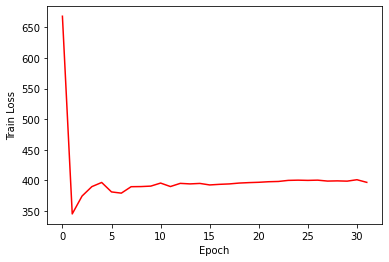

In [25]:
plt.plot(np.arange(len(train_losses)), train_losses, 'r')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

In [41]:
# class ConvNet(LightningModule):
#     def __init__(self):
#       super().__init__()

#       self.conv1 = nn.Sequential( 
#                         nn.Conv1d(
#                             in_channels=1,
#                             out_channels=200,
#                             kernel_size=4, 
#                             stride=3, 
#                             padding = 0) 
                        
#                         ,nn.ReLU()
#       )
      
#       self.conv2 = nn.Sequential (
#                         nn.Conv1d(
#                             in_channels = 200,
#                             out_channels = 200,
#                             kernel_size = 5, 
#                             stride = 1, 
#                             padding = 0)
                        
#                         ,nn.ReLU()
#       )

#       self.maxpool = nn.MaxPool1d(2)

#       # use a dummy input to calculate
#       random_input = torch.rand(1, 1, 1500 , requires_grad=False)
#       random_input = self.conv1(random_input)
#       random_input = self.conv2(random_input)
#       random_input = self.maxpool(random_input)
#       maxpool_out = random_input.view(1, -1).shape[1]

#       self.fc1 = nn.Sequential(
#             nn.Linear(
#                 in_features= maxpool_out,
#                 out_features=200
#             ),
#             nn.Dropout(p=0.05),
#             nn.ReLU()
#         )
      

#       self.fc2 = nn.Sequential(
#             nn.Linear(
#                 in_features=200,
#                 out_features=100
#             ),
#             nn.Dropout(p=0.05),
#             nn.ReLU()
#         )


#       self.fc3 = nn.Sequential(
#             nn.Linear(
#                 in_features=100,
#                 out_features=50
#             ),
#             nn.Dropout(p=0.05),
#             nn.ReLU()
#         )
      
#       self.out = nn.Linear(
#             in_features=50,
#             out_features=3
#         )


#     def forward(self, x):

#       # x = x.view(x.size(0), -1)

#       x = self.conv1(x)
#       x = self.conv2(x)
#       x = self.maxpool(x)

#       #flatten
#       x = x.reshape(batch_size, -1)

#       #3fc
#       x = self.fc1(x)
#       x = self.fc2(x)
#       x = self.fc3(x)

#       #output
#       x = self.out(x)
#       output = nn.Softmax(x , dim=1)

#       return output


#     def training_step(self, batch, batch_idx):
#       x , y = batch
#       y_hat = self(x)
#       print(y)
#       loss = {'loss': F.cross_entropy(y_hat, y)}
#       return loss

#     # def validation_step(self, batch, batch_idx):
      
#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=0.0001)